In [1]:

import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt

#Libraries for formattting and handling text 
import string 
import re

#Library for nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS



#Library for Splitting Dataset
from sklearn.model_selection import train_test_split


#Libraries for NN
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout , BatchNormalization ,GRU
from tensorflow.keras.utils import plot_model
from keras import layers
#Library for evaluation
from sklearn import metrics
from functools import reduce
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

#Upload dataset

In [2]:
from google.colab import files
uploaded = files.upload()

Saving sample_submission.csv to sample_submission.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


In [3]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
sample_sub=pd.read_csv('sample_submission.csv')


#Text Analysis

In [ ]:
train_data.head().style.background_gradient(cmap='coolwarm')


,id,keyword,location,text,target
0,1,nan,nan,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,nan,nan,Forest fire near La Ronge Sask. Canada,1
2,5,nan,nan,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,nan,nan,"13,000 people receive #wildfires evacuation orders in California",1
4,7,nan,nan,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


#Heat Map

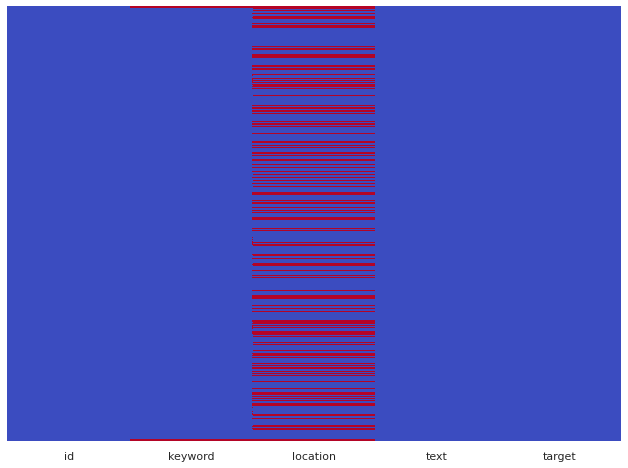

In [ ]:
sns.set(rc={'figure.figsize':(11,8)})
sns.heatmap(train_data.isnull(),yticklabels=False,cbar=False,cmap="coolwarm")

#Analysis and Visualisation of Target

In [ ]:
train_data['target'].value_counts()



0    4342
1    3271
Name: target, dtype: int64

Text(0.5, 1.0, 'Target Distributions \n (0: Non Disaster || 1: Disaster)')

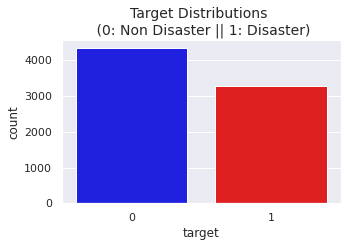

In [ ]:
plt.figure(figsize=(5,3))
colors = ["blue", "red"]

sns.countplot(x = 'target', data=train_data, palette=colors)
plt.title('Target Distributions \n (0: Non Disaster || 1: Disaster)', fontsize=14)

#Analysis and Visualisation of Features

In [ ]:
train_data["keyword"].nunique()

221

Text(0.5, 0, 'Count of Keywords')

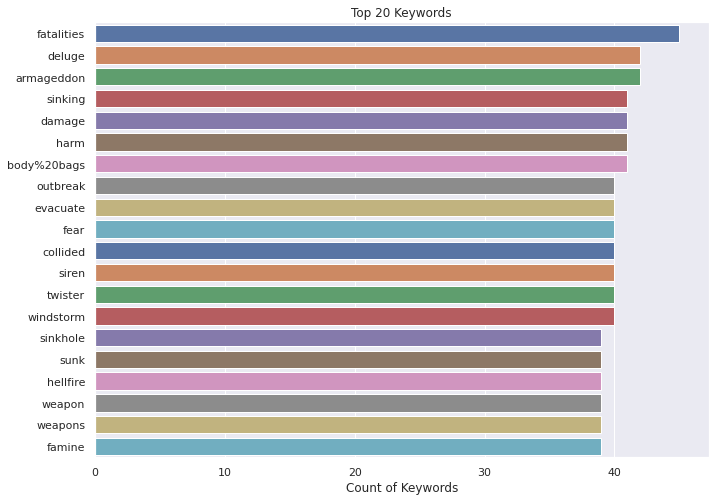

In [ ]:
chains=train_data['keyword'].value_counts()[:20]
sns.barplot(x=chains,y=chains.index,palette='deep')
plt.title("Top 20 Keywords")
plt.xlabel("Count of Keywords")

#Plotting top 20 disaster and non disaster keywords

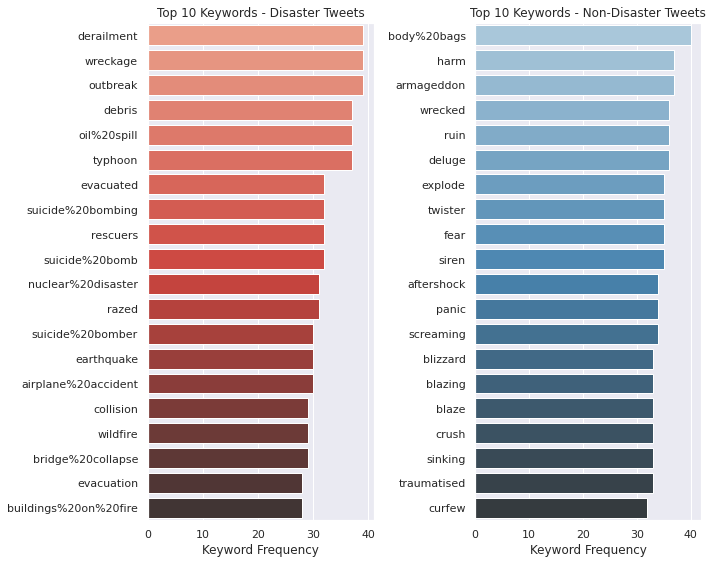

In [ ]:
disaster_keywords = train_data.loc[train_data["target"] == 1]["keyword"].value_counts()
nondisaster_keywords = train_data.loc[train_data["target"] == 0]["keyword"].value_counts()

fig, ax = plt.subplots(1,2, figsize=(10,8))
sns.barplot(y=disaster_keywords[0:20].index, x=disaster_keywords[0:20], orient='h', ax=ax[0], palette="Reds_d")
ax[0].set_title("Top 10 Keywords - Disaster Tweets")
ax[0].set_xlabel("Keyword Frequency")

sns.barplot(y=nondisaster_keywords[0:20].index, x=nondisaster_keywords[0:20], orient='h', ax=ax[1], palette="Blues_d")
ax[1].set_title("Top 10 Keywords - Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")


plt.tight_layout()
plt.show()

#Plotting highest usage disaster keyword and lowest usage disaster keyword

In [ ]:
top_disaster_keyword = train_data.groupby('keyword').mean()['target'].sort_values(ascending = False).head(10)
top_nondisaster_keyword = train_data.groupby('keyword').mean()['target'].sort_values().head(10)

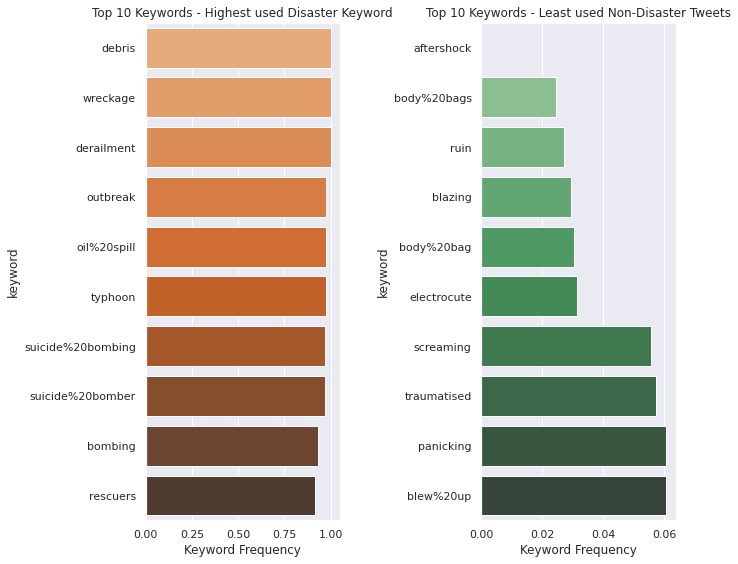

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,8))

sns.barplot(y=top_disaster_keyword[0:20].index, x=top_disaster_keyword[0:20], orient='h', ax=ax[0], palette="Oranges_d")
ax[0].set_title("Top 10 Keywords - Highest used Disaster Keyword")
ax[0].set_xlabel("Keyword Frequency")


sns.barplot(y=top_nondisaster_keyword[0:20].index, x=top_nondisaster_keyword[0:20], orient='h', ax=ax[1], palette="Greens_d")
ax[1].set_title("Top 10 Keywords - Least used Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")


plt.tight_layout()
plt.show()

In [ ]:
locations = train_data["location"].value_counts()

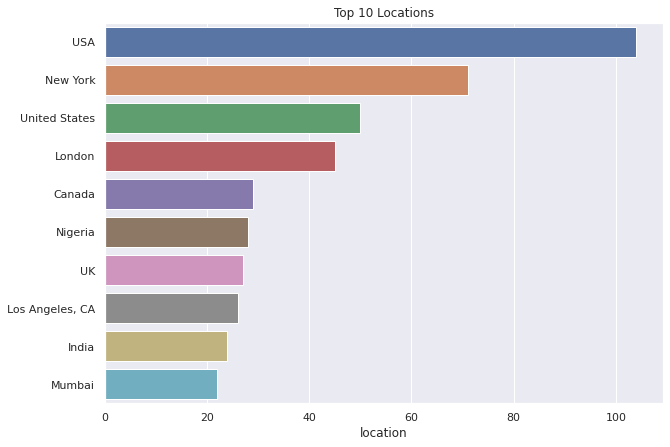

In [ ]:
plt.figure(figsize=(10,7))


sns.barplot(y=locations[0:10].index, x=locations[0:10], orient='h')

plt.title("Top 10 Locations")
plt.show()

In [ ]:
print(len(train_data['text']))

7613


In [ ]:
train_data["length"]  = train_data["text"].apply(len)
train_data.head().style.background_gradient(cmap='coolwarm')

,id,keyword,location,text,target,length
0,1,nan,nan,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,69
1,4,nan,nan,Forest fire near La Ronge Sask. Canada,1,38
2,5,nan,nan,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,133
3,6,nan,nan,"13,000 people receive #wildfires evacuation orders in California",1,65
4,7,nan,nan,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,88


In [ ]:
train_data['length'].describe()

count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

In [ ]:
train_data[train_data['length']==157]['text'].iloc[0]

"when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned??????????????????????????????????????????????????"

#Plotting tweets length

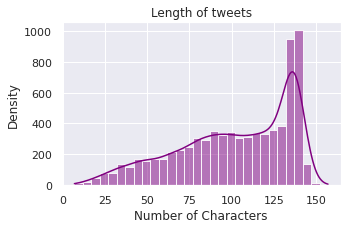

In [ ]:
plt.figure(figsize=(5,3))
sns.histplot(train_data["length"], kde=True,color='purple',bins=30)
plt.title("Length of tweets")
plt.xlabel("Number of Characters")
plt.ylabel("Density")
plt.show()

#Plotting tweets length wrt target

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1797d98d90>,
      dtype=object)

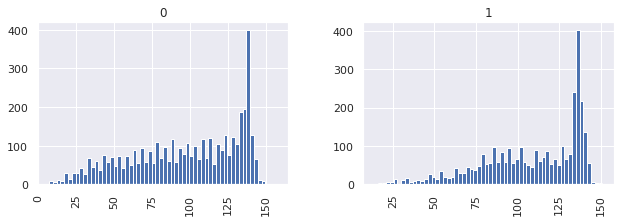

In [ ]:
train_data.hist(column='length', by = 'target',bins =60, figsize= (10,3))

#Plotting number of words in tweets

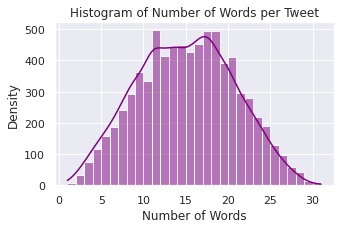

In [ ]:
def count_words(x):
    return len(x.split())

train_data["num_words"] = train_data["text"].apply(count_words)

plt.figure(figsize=(5,3))
sns.histplot(train_data["num_words"],kde=True,color='purple',bins=30)
plt.title("Histogram of Number of Words per Tweet")
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.show()

#Plotting number of words in tweets wrt target

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1797de8ed0>,
      dtype=object)

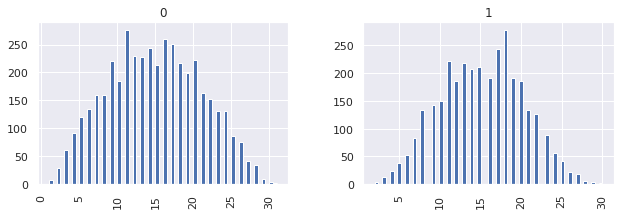

In [ ]:
train_data.hist(column='num_words', by = 'target',bins =60, figsize= (10,3))

#Text Preprocessing

In [4]:
def toclean_text(text):
  
  clean_text=text.translate(str.maketrans('', '', string.punctuation))
  return clean_text

In [5]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [6]:
# Remove all URLs, replace by URL
def remove_URL(text):
  url = re.compile(r'https?://\S+|www\.\S+')
  
  return url.sub(r'',text)


# Remove HTML beacon
def remove_HTML(text):
  html=re.compile(r'<.*?>')
  
  return html.sub(r'',text)

# Remove non printable characters
def remove_not_ASCII(text):
  text = ''.join([word for word in text if word in string.printable])
  
  return text


# Change an abbreviation by its true meaning
def word_abbrev(word):
      return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word


# Replace all abbreviations
def replace_abbrev(text):
  string = ""
  for word in text.split():
    string += word_abbrev(word) + " "
  
  return string


# Remove @ and mention, replace by USER
def remove_mention(text):
  at=re.compile(r'@\S+')
  
  return at.sub(r'USER',text)

   
# Remove numbers, replace it by NUMBER
def remove_number(text):
  num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
  
  return num.sub(r'NUMBER', text)

   
# Remove all emojis, replace by EMOJI
def remove_emoji(text):
  emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'EMOJI', text)


# Replace some others smileys with SADFACE
def transcription_sad(text):
  eyes = "[8:=;]"
  nose = "['`\-]"
  smiley = re.compile(r'[8:=;][\'\-]?[(\\/]')
  return smiley.sub(r'SADFACE', text)
   

# Replace some smileys with SMILE
def transcription_smile(text):
  eyes = "[8:=;]"
  nose = "['`\-]"
  #smiley = re.compile(r'[8:=;][\'\-]?[)dDp]')
  smiley = re.compile(r'#{eyes}#{nose}[)d]+|[)d]+#{nose}#{eyes}/i')
  return smiley.sub(r'SMILE', text)
  

# Replace <3 with HEART
def transcription_heart(text):
  heart = re.compile(r'<3')
  return heart.sub(r'HEART', text)
    



In [7]:
def clean_tweet(text):
    
    # Remove non text
    text = remove_URL(text)
    text = remove_HTML(text)
    text = remove_not_ASCII(text)
    
    # replace abbreviations, @ and number
    text = replace_abbrev(text)  
    text = remove_mention(text)
    text = remove_number(text)
    
    # Remove emojis / smileys
    text = remove_emoji(text)
    text = transcription_sad(text)
    text = transcription_smile(text)
    text = transcription_heart(text)
  
    return text

In [8]:
train_data['clean_text'] = train_data["text"].apply(toclean_text)
test_data['clean_text'] = test_data["text"].apply(toclean_text)
train_data['clean_tweet'] = train_data["clean_text"].apply(clean_tweet)
test_data['clean_tweet'] = test_data["clean_text"].apply(clean_tweet)

train_data.head().style.background_gradient(cmap='coolwarm')
#test_data.head().style.background_gradient(cmap='coolwarm')

,id,keyword,location,text,target,clean_text,clean_tweet
0,1,nan,nan,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,Our Deeds are the Reason of this earthquake May ALLAH Forgive us all,Our Deeds are the Reason of this earthquake May ALLAH Forgive us all
1,4,nan,nan,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,Forest fire near La Ronge Sask Canada
2,5,nan,nan,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,All residents asked to shelter in place are being notified by officers No other evacuation or shelter in place orders are expected,All residents asked to shelter in place are being notified by officers No other evacuation or shelter in place orders are expected
3,6,nan,nan,"13,000 people receive #wildfires evacuation orders in California",1,13000 people receive wildfires evacuation orders in California,NUMBER people receive wildfires evacuation orders in California
4,7,nan,nan,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school,Just got sent this photo from Ruby Alaska as smoke from wildfires pours into a school


In [9]:
import nltk ;nltk.download('popular')
  

#convert all the words into lower case
train_data['clean_tweet'] = train_data['clean_tweet'].str.lower()
test_data['clean_tweet'] = test_data['clean_tweet'].str.lower()


# set of stop words
stopword = set(stopwords.words('english')) 

# tokens of words  
train_data['tokenized_sents'] = train_data.apply(lambda row: nltk.word_tokenize(row['clean_tweet']), axis=1)
test_data['tokenized_sents'] = test_data.apply(lambda row: nltk.word_tokenize(row['clean_tweet']), axis=1)

#function to remove stop words
def remove_stops(row):
    my_list = row['tokenized_sents']
    meaningful_words = [w for w in my_list if not w in stopword]
    return (meaningful_words)

#removing stop words
train_data['clean_tokenized'] = train_data.apply(remove_stops, axis=1)
train_data.drop(["clean_tweet",'tokenized_sents'], axis = 1, inplace = True)
test_data['clean_tokenized'] = test_data.apply(remove_stops, axis=1)
test_data.drop(["clean_tweet",'tokenized_sents'], axis = 1, inplace = True)

#re-join the words after tokenization
def rejoin_words(row):
    my_list = row['clean_tokenized']
    joined_words = ( " ".join(my_list))
    return joined_words

train_data['rejoined_text'] = train_data.apply(rejoin_words, axis=1)
train_data.head()
test_data['rejoined_text'] = test_data.apply(rejoin_words, axis=1)
test_data.head()




[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

,id,keyword,location,text,clean_text,clean_tokenized,rejoined_text
0,0,NaN,NaN,Just happened a terrible car crash,Just happened a terrible car crash,"[happened, terrible, car, crash]",happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",Heard about earthquake is different cities sta...,"[heard, earthquake, different, cities, stay, s...",heard earthquake different cities stay safe ev...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",there is a forest fire at spot pond geese are ...,"[forest, fire, spot, pond, geese, fleeing, acr...",forest fire spot pond geese fleeing across str...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting Spokane wildfires,"[apocalypse, lighting, spokane, wildfires]",apocalypse lighting spokane wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 in China and Taiwan,"[typhoon, soudelor, kills, number, china, taiwan]",typhoon soudelor kills number china taiwan


In [10]:
#Define tokenizer and padding

tweet = train_data.loc[:,train_data.columns=='rejoined_text'].values.flatten()
tweet_test = test_data.loc[:,test_data.columns=='rejoined_text'].values.flatten()

tokenizer= Tokenizer(num_words=5000)
def tokenize(text):
    seqs = tokenizer.fit_on_texts(text)
    return seqs

tokens=tokenize(tweet)
tokens_test=tokenize(tweet_test)

X_train = tokenizer.texts_to_sequences(tweet)
X_test = tokenizer.texts_to_sequences(tweet_test)
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index






In [15]:
train_data["length-1"]  = train_data["rejoined_text"].apply(len)
train_data["length-1"].describe()

count    7613.000000
mean       82.673191
std        31.097183
min         3.000000
25%        61.000000
50%        85.000000
75%       107.000000
max       172.000000
Name: length-1, dtype: float64

In [11]:

maxlen =172

X_train = np.array(X_train, dtype=object)
X_test = np.array(X_test, dtype=object)

X_train = keras.preprocessing.sequence.pad_sequences(X_train ,padding='post', maxlen=maxlen)
X_test = keras.preprocessing.sequence.pad_sequences(X_test ,padding='post', maxlen=maxlen)



In [12]:
# validation split
y_train = train_data.target.values
x_train, x_val, y, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print("Training data shape: ", x_train.shape)
print("Validation data shape: ", x_val.shape)

Training data shape:  (6090, 172)
Validation data shape:  (1523, 172)


In [18]:
#creating model

embedding_dim = 50

model = Sequential()
model.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 172, 50)           1392850   
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,393,371
Trainable params: 1,393,371
Non-trainable params: 0
_________________________________________________________________


In [19]:
history = model.fit(x_train, y, validation_data=(x_val,y_val), shuffle=True, epochs=5, batch_size=64)


Epoch 1/5
96/96 [==============================] - 3s 25ms/step - loss: 0.6697 - accuracy: 0.5791 - val_loss: 0.6405 - val_accuracy: 0.6264
Epoch 2/5
96/96 [==============================] - 2s 22ms/step - loss: 0.5616 - accuracy: 0.7673 - val_loss: 0.5091 - val_accuracy: 0.8004
Epoch 3/5
96/96 [==============================] - 3s 30ms/step - loss: 0.3795 - accuracy: 0.8609 - val_loss: 0.4469 - val_accuracy: 0.7978
Epoch 4/5
96/96 [==============================] - 2s 22ms/step - loss: 0.2775 - accuracy: 0.8952 - val_loss: 0.4564 - val_accuracy: 0.8030
Epoch 5/5
96/96 [==============================] - 2s 22ms/step - loss: 0.2128 - accuracy: 0.9230 - val_loss: 0.4923 - val_accuracy: 0.7794


In [16]:
# Showing Confusion Matrix 
def plot_cm(y, y_pre, title, figsize=(5,5)):
    cm = confusion_matrix(y, y_pre, labels=np.unique(y))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y), columns=np.unique(y))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

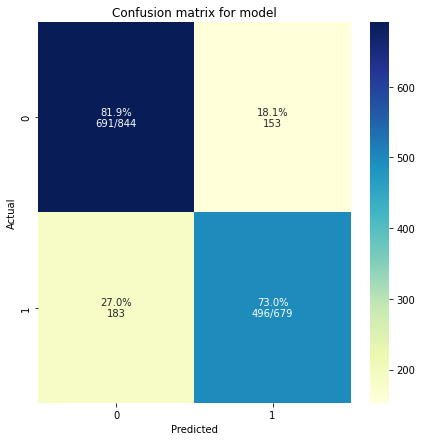

In [23]:
y_pred=model.predict(x_val)
y_pred=np.round(y_pred).astype(int).reshape(1523)


plot_cm(y_pred, y_val, 'Confusion matrix for model', figsize=(7,7))

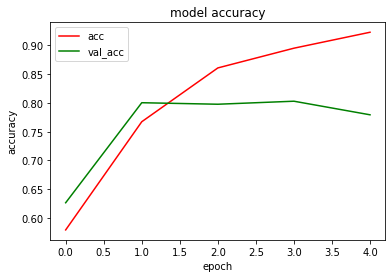

Training Accuracy:  0.9229885339736938
validation Accuracy:  0.7793828248977661


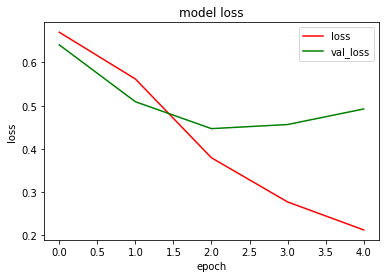

Training loss:  0.21281491219997406
validation loss:  0.4923231899738312


In [24]:
plt.plot(history.history['accuracy'], label='acc', color='red')
plt.plot(history.history['val_accuracy'], label='val_acc', color='green')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()
print("Training Accuracy: ",history.history['accuracy'][-1] )
print("validation Accuracy: ",history.history['val_accuracy'][-1] )


plt.plot(history.history['loss'], label='loss', color='red')
plt.plot(history.history['val_loss'], label='val_loss', color='green')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
print("Training loss: ",history.history['loss'][-1] )
print("validation loss: ",history.history['val_loss'][-1] )

In [25]:
model.evaluate(x_val, y_val)

48/48 [==============================] - 0s 2ms/step - loss: 0.4923 - accuracy: 0.7794


[0.4923231303691864, 0.7793828248977661]

#Model creation Using LSTM and GRU

In [26]:
#creating model with LSTM

embedding_dim = 50

model1 = Sequential()
model1.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model1.add(LSTM(100, return_sequences = True))
model1.add(layers.GlobalMaxPool1D())
model1.add(BatchNormalization())
model1.add(Dropout(0.5))
model1.add(layers.Dense(10, activation='relu'))
model1.add(Dropout(0.2))
model1.add(layers.Dense(1, activation='sigmoid'))
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 172, 50)           1392850   
                                                                 
 lstm (LSTM)                 (None, 172, 100)          60400     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 batch_normalization (BatchN  (None, 100)              400       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 10)               

In [27]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
history1 = model1.fit(x_train, y, validation_data=(x_val,y_val), shuffle=True, epochs=5, batch_size=64,callbacks = [callback])


Epoch 1/5
96/96 [==============================] - 27s 248ms/step - loss: 0.5930 - accuracy: 0.6972 - val_loss: 0.6422 - val_accuracy: 0.7571
Epoch 2/5
96/96 [==============================] - 34s 361ms/step - loss: 0.3941 - accuracy: 0.8401 - val_loss: 0.5887 - val_accuracy: 0.7938
Epoch 3/5
96/96 [==============================] - 25s 258ms/step - loss: 0.2947 - accuracy: 0.8851 - val_loss: 0.5296 - val_accuracy: 0.7584
Epoch 4/5
96/96 [==============================] - 24s 248ms/step - loss: 0.2529 - accuracy: 0.9038 - val_loss: 0.4918 - val_accuracy: 0.7853
Epoch 5/5
96/96 [==============================] - 23s 238ms/step - loss: 0.2146 - accuracy: 0.9177 - val_loss: 0.5221 - val_accuracy: 0.7695


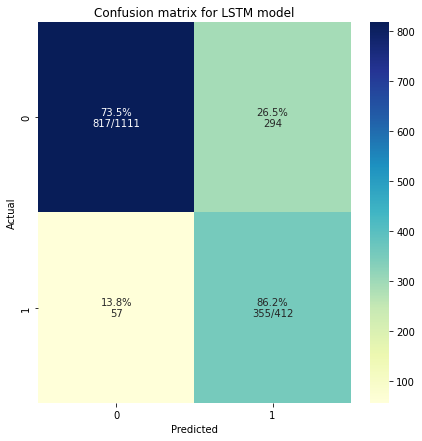

In [28]:
y_pred=model1.predict(x_val)
y_pred=np.round(y_pred).astype(int).reshape(1523)


plot_cm(y_pred, y_val, 'Confusion matrix for LSTM model', figsize=(7,7))

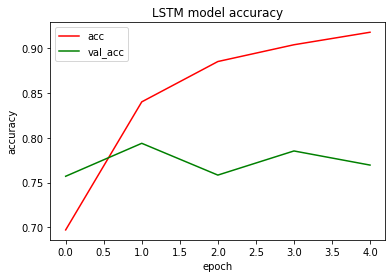

Training Accuracy:  0.9177339673042297
validation Accuracy:  0.7695338129997253


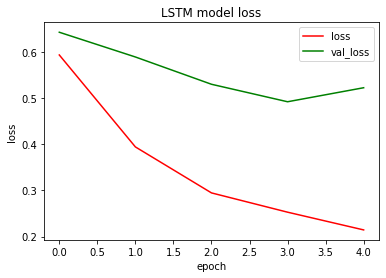

Training loss:  0.2145729959011078
validation loss:  0.5221458077430725


In [29]:
plt.plot(history1.history['accuracy'], label='acc', color='red')
plt.plot(history1.history['val_accuracy'], label='val_acc', color='green')
plt.title('LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()
print("Training Accuracy: ",history1.history['accuracy'][-1] )
print("validation Accuracy: ",history1.history['val_accuracy'][-1] )


plt.plot(history1.history['loss'], label='loss', color='red')
plt.plot(history1.history['val_loss'], label='val_loss', color='green')
plt.title('LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
print("Training loss: ",history1.history['loss'][-1] )
print("validation loss: ",history1.history['val_loss'][-1] )

In [30]:
#creating model with GRU

embedding_dim = 50

model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model2.add(GRU(100, return_sequences = True))
model2.add(layers.GlobalMaxPool1D())
model2.add(BatchNormalization())
model2.add(Dropout(0.5))
model2.add(layers.Dense(10, activation='relu'))
model2.add(Dropout(0.2))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 172, 50)           1392850   
                                                                 
 gru (GRU)                   (None, 172, 100)          45600     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 batch_normalization_1 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 10)               

In [31]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
history2 = model2.fit(x_train, y, validation_data=(x_val,y_val), shuffle=True, epochs=5, batch_size=64,callbacks = [callback])


Epoch 1/5
96/96 [==============================] - 27s 249ms/step - loss: 0.6129 - accuracy: 0.6585 - val_loss: 0.6580 - val_accuracy: 0.5739
Epoch 2/5
96/96 [==============================] - 28s 292ms/step - loss: 0.4202 - accuracy: 0.8286 - val_loss: 0.6162 - val_accuracy: 0.6454
Epoch 3/5
96/96 [==============================] - 19s 201ms/step - loss: 0.3107 - accuracy: 0.8701 - val_loss: 0.5435 - val_accuracy: 0.7610
Epoch 4/5
96/96 [==============================] - 20s 210ms/step - loss: 0.2542 - accuracy: 0.9000 - val_loss: 0.4852 - val_accuracy: 0.7820
Epoch 5/5
96/96 [==============================] - 19s 201ms/step - loss: 0.2160 - accuracy: 0.9167 - val_loss: 0.4785 - val_accuracy: 0.7800


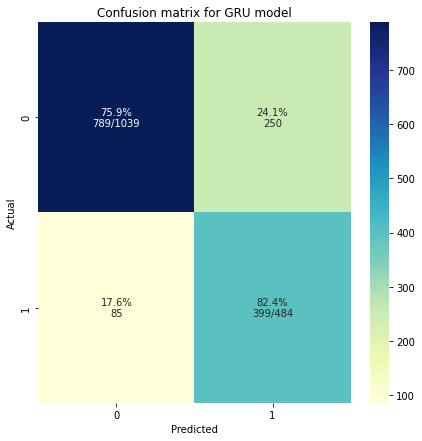

In [32]:
y_pred=model2.predict(x_val)
y_pred=np.round(y_pred).astype(int).reshape(1523)


plot_cm(y_pred, y_val, 'Confusion matrix for GRU model', figsize=(7,7))

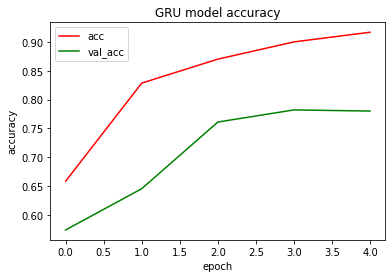

Training Accuracy:  0.9167487621307373
validation Accuracy:  0.780039370059967


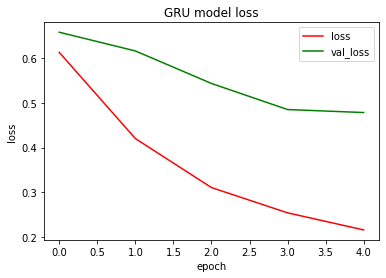

Training loss:  0.2159973680973053
validation loss:  0.4784756302833557


In [33]:
plt.plot(history2.history['accuracy'], label='acc', color='red')
plt.plot(history2.history['val_accuracy'], label='val_acc', color='green')
plt.title('GRU model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()
print("Training Accuracy: ",history2.history['accuracy'][-1] )
print("validation Accuracy: ",history2.history['val_accuracy'][-1] )


plt.plot(history2.history['loss'], label='loss', color='red')
plt.plot(history2.history['val_loss'], label='val_loss', color='green')
plt.title('GRU model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
print("Training loss: ",history2.history['loss'][-1] )
print("validation loss: ",history2.history['val_loss'][-1] )

In [34]:
#creating model with GRU & LSTM

embedding_dim = 50

model3 = Sequential()
model3.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model3.add(GRU(100, return_sequences = True))
model3.add(Dropout(0.2))
model3.add(LSTM(100, return_sequences = True))
model3.add(Dropout(0.2))
model3.add(layers.GlobalMaxPool1D())
model3.add(BatchNormalization())
model3.add(Dropout(0.5))
model3.add(layers.Dense(10, activation='relu'))
model3.add(Dropout(0.2))
model3.add(layers.Dense(1, activation='sigmoid'))
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 172, 50)           1392850   
                                                                 
 gru_1 (GRU)                 (None, 172, 100)          45600     
                                                                 
 dropout_4 (Dropout)         (None, 172, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 172, 100)          80400     
                                                                 
 dropout_5 (Dropout)         (None, 172, 100)          0         
                                                                 
 global_max_pooling1d_3 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                      

In [35]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
history3 = model3.fit(x_train, y, validation_data=(x_val,y_val), shuffle=True, epochs=5, batch_size=64,callbacks = [callback])


Epoch 1/5
96/96 [==============================] - 48s 455ms/step - loss: 0.5952 - accuracy: 0.6780 - val_loss: 0.6303 - val_accuracy: 0.7144
Epoch 2/5
96/96 [==============================] - 44s 464ms/step - loss: 0.3993 - accuracy: 0.8356 - val_loss: 0.6055 - val_accuracy: 0.7958
Epoch 3/5
96/96 [==============================] - 43s 450ms/step - loss: 0.3098 - accuracy: 0.8767 - val_loss: 0.5216 - val_accuracy: 0.7859
Epoch 4/5
96/96 [==============================] - 43s 447ms/step - loss: 0.2550 - accuracy: 0.8987 - val_loss: 0.5100 - val_accuracy: 0.7636
Epoch 5/5
96/96 [==============================] - 43s 450ms/step - loss: 0.2150 - accuracy: 0.9092 - val_loss: 0.5025 - val_accuracy: 0.7643


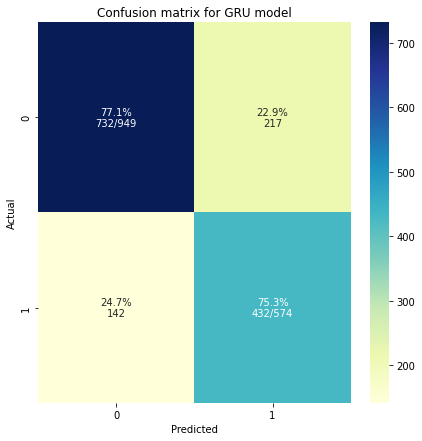

In [36]:
y_pred=model3.predict(x_val)
y_pred=np.round(y_pred).astype(int).reshape(1523)


plot_cm(y_pred, y_val, 'Confusion matrix for GRU model', figsize=(7,7))

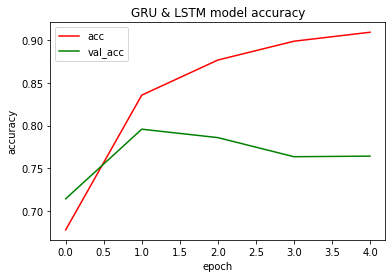

Training Accuracy:  0.9091954231262207
validation Accuracy:  0.7642810344696045


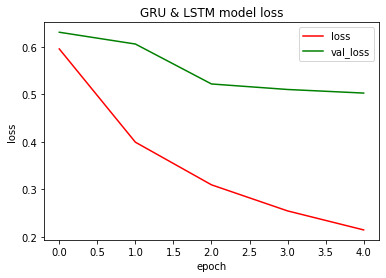

Training loss:  0.21501819789409637
validation loss:  0.5025151968002319


In [37]:
plt.plot(history3.history['accuracy'], label='acc', color='red')
plt.plot(history3.history['val_accuracy'], label='val_acc', color='green')
plt.title('GRU & LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()
print("Training Accuracy: ",history3.history['accuracy'][-1] )
print("validation Accuracy: ",history3.history['val_accuracy'][-1] )


plt.plot(history3.history['loss'], label='loss', color='red')
plt.plot(history3.history['val_loss'], label='val_loss', color='green')
plt.title('GRU & LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
print("Training loss: ",history3.history['loss'][-1] )
print("validation loss: ",history3.history['val_loss'][-1] )

In [13]:

#best model

embedding_dim = 32

model5 = Sequential()
model5.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model5.add(GRU(64, return_sequences = True))
model5.add(layers.GlobalMaxPool1D())
model5.add(BatchNormalization())
model5.add(Dropout(0.5))
model5.add(layers.Dense(10, activation='tanh'))
model5.add(Dropout(0.2))
model5.add(layers.Dense(1, activation='sigmoid'))
model5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 172, 32)           891424    
                                                                 
 gru (GRU)                   (None, 172, 64)           18816     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 10)                6

In [14]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
history5 = model5.fit(x_train, y, validation_data=(x_val,y_val), shuffle=True, epochs=5, batch_size=64,callbacks = [callback])

Epoch 1/5
96/96 [==============================] - 16s 138ms/step - loss: 0.5972 - accuracy: 0.6711 - val_loss: 0.6533 - val_accuracy: 0.5752
Epoch 2/5
96/96 [==============================] - 13s 131ms/step - loss: 0.4001 - accuracy: 0.8320 - val_loss: 0.6055 - val_accuracy: 0.7236
Epoch 3/5
96/96 [==============================] - 12s 129ms/step - loss: 0.3093 - accuracy: 0.8777 - val_loss: 0.5504 - val_accuracy: 0.7958
Epoch 4/5
96/96 [==============================] - 14s 145ms/step - loss: 0.2751 - accuracy: 0.8964 - val_loss: 0.4951 - val_accuracy: 0.7945
Epoch 5/5
96/96 [==============================] - 13s 138ms/step - loss: 0.2256 - accuracy: 0.9126 - val_loss: 0.4734 - val_accuracy: 0.7768


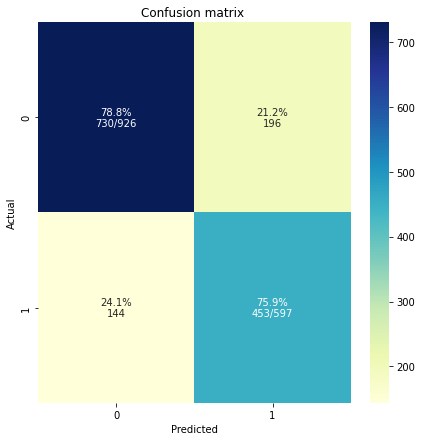

In [17]:
y_pred=model5.predict(x_val)
y_pred=np.round(y_pred).astype(int).reshape(1523)


plot_cm(y_pred, y_val, 'Confusion matrix ', figsize=(7,7))

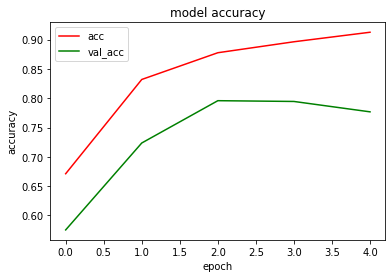

Training Accuracy:  0.9126436710357666
validation Accuracy:  0.7767564058303833


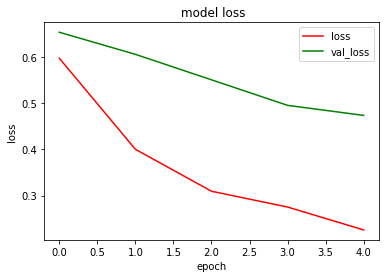

Training loss:  0.2256191074848175
validation loss:  0.4734223484992981


In [18]:
plt.plot(history5.history['accuracy'], label='acc', color='red')
plt.plot(history5.history['val_accuracy'], label='val_acc', color='green')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()
print("Training Accuracy: ",history5.history['accuracy'][-1] )
print("validation Accuracy: ",history5.history['val_accuracy'][-1] )


plt.plot(history5.history['loss'], label='loss', color='red')
plt.plot(history5.history['val_loss'], label='val_loss', color='green')
plt.title(' model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
print("Training loss: ",history5.history['loss'][-1] )
print("validation loss: ",history5.history['val_loss'][-1] )

In [19]:
y_pre=model5.predict(X_test)
y_pre=np.round(y_pre).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('submission.csv',index=False)

